In [1]:
import numpy 
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch_geometric.utils import remove_self_loops, add_self_loops, add_remaining_self_loops, degree
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam

from math import sqrt

In [3]:
%run graph.ipynb
slider_data,slider_adj_matrix = create_graph_pyg_usable(master_df)

In [4]:
print(slider_data)

Data(x=[734160, 103], edge_index=[2, 5873260], y=[734160], norm=[6607420])


In [5]:

# Graph Convolution Layer
class GraphConvolution(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(GraphConvolution, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.weight = nn.Parameter(torch.Tensor(input_dim, output_dim))
        self.bias = nn.Parameter(torch.Tensor(output_dim))
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.weight)
        nn.init.zeros_(self.bias)

    def forward(self, x, adj):
        support = torch.matmul(x, self.weight)
        output = torch.sparse.mm(adj, support)
        output = output + self.bias
        return F.relu(output)

# GCN Model
class GCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.gc1 = GraphConvolution(input_dim, hidden_dim)
        self.gc2 = GraphConvolution(hidden_dim, output_dim)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x, adj):
        x = self.gc1(x, adj)
        x = self.dropout(x)
        x = self.gc2(x, adj)
        return x

In [7]:
def rmse(predictions, targets):
    return sqrt(((predictions - targets) ** 2).mean().item())


def train_gcn_model(model, data, adj_matrix, epochs=150, lr=0.01, accumulation_steps=5, clip_value=2,stop_loss=1.5):
    optimizer = Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    # Normalize the input features once before training
    mean = data.x.mean(dim=0)
    std = data.x.std(dim=0)
    data.x = (data.x - mean) / std

    losses = []
    rmses =[]

    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        accumulated_loss = 0.0

        for i in range(accumulation_steps):
            output = model(data.x, adj_matrix)
            loss = criterion(output.view(-1), data.y)
            loss.backward()
            accumulated_loss += loss.item() / accumulation_steps

        nn.utils.clip_grad_norm_(model.parameters(), clip_value)
        optimizer.step()

        losses.append(accumulated_loss)

        if accumulated_loss <= stop_loss:
            print(f"Early stopping as accumulated loss went below stop loss")
            print(f"Epoch {epoch + 1},Loss : {accumulated_loss}")
            break

        rmse_val = rmse(output.view(-1), data.y)
        rmses.append(rmse_val)
        print(f'Epoch {epoch + 1},Loss: {accumulated_loss}')
    
    return rmses,losses
gcn_model = GCN(input_dim=slider_data.x.size(1), hidden_dim=32, output_dim=1)
rmses,losses = train_gcn_model(gcn_model, slider_data, slider_adj_matrix, epochs=200, lr=0.001, accumulation_steps=10, clip_value=1,stop_loss = 1.5)



Epoch 1,Loss: 292266099.2
Epoch 2,Loss: 257230756.79999998
Epoch 3,Loss: 214153003.2
Epoch 4,Loss: 188131492.8
Epoch 5,Loss: 158472011.20000002
Epoch 6,Loss: 135417506.4
Epoch 7,Loss: 113616886.4
Epoch 8,Loss: 94563865.6
Epoch 9,Loss: 81153970.4
Epoch 10,Loss: 65742433.6
Epoch 11,Loss: 54676586.0
Epoch 12,Loss: 44658431.99999999
Epoch 13,Loss: 36320869.199999996
Epoch 14,Loss: 29571084.2
Epoch 15,Loss: 22997857.4
Epoch 16,Loss: 17933405.4
Epoch 17,Loss: 13955975.1
Epoch 18,Loss: 10666654.000000002
Epoch 19,Loss: 8204707.599999999
Epoch 20,Loss: 6215656.3
Epoch 21,Loss: 4653295.0
Epoch 22,Loss: 3416054.525
Epoch 23,Loss: 2484458.6374999997
Epoch 24,Loss: 1811373.4000000001
Epoch 25,Loss: 1380237.4999999998
Epoch 26,Loss: 858370.25625
Epoch 27,Loss: 660291.4781249999
Epoch 28,Loss: 448017.778125
Epoch 29,Loss: 346521.7703125
Epoch 30,Loss: 179887.196875
Epoch 31,Loss: 132373.97890624998
Epoch 32,Loss: 87014.490234375
Epoch 33,Loss: 52579.42734375
Epoch 34,Loss: 21591.703466796873
Epoch 3

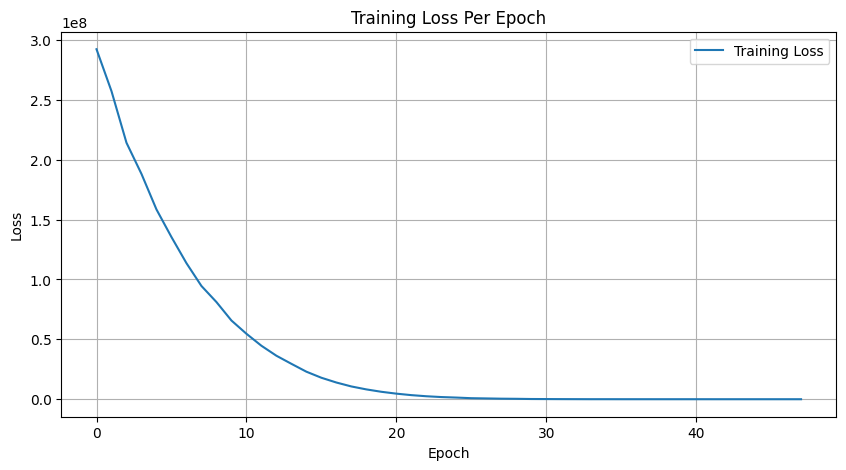

In [8]:
# Plotting the Losses

plt.figure(figsize=(10, 5))
plt.plot(losses, label='Training Loss')
plt.title('Training Loss Per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()



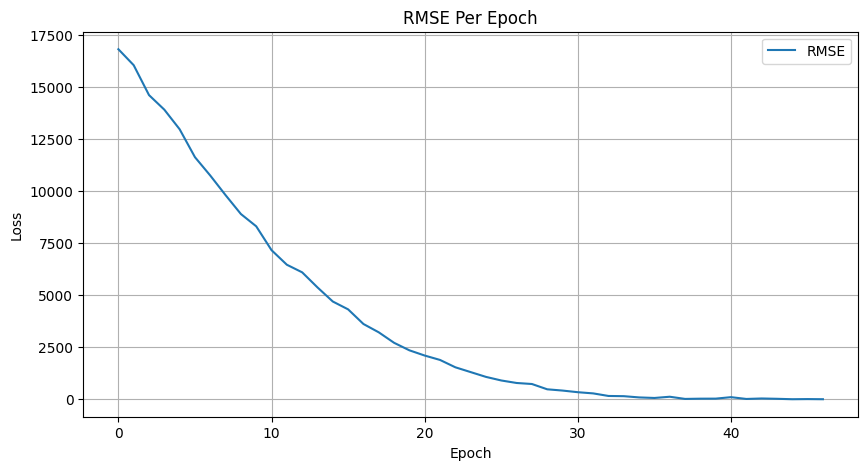

In [9]:
# Plotting the RMSE

plt.figure(figsize=(10, 5))
plt.plot(rmses, label='RMSE')
plt.title('RMSE Per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

